In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gvar as gv
import lsqfit as lf


######################### FUNCTIONAL FORM FOR FITTING #########################
## Gaussian function,
##    for fitting the profile at any given time.
## Adjustable parameters (in order):
##    amplitude, width, y-offset, x-offset
def gauss_f(x,p):
    return p[0]*np.exp( -0.5*((x-p[3])/p[1])**2 ) + p[2]

## Doubly decaying function,
##    for fitting the time evolution of the fwhm.
## Adjustable parameters (in order):
##    length scales for 2 decaying and 1 constants,
##    time scales for the 2 decays
def x_fwhm(t,p):
    t = t.astype(float)
    return (p[0]*np.exp( -(t)/p[3] ) + p[1]*np.exp( -t/p[4] ) + p[2])*(4*np.log(2))**0.5

####################### END FUNCTIONAL FORM FOR FITTING #######################


############################### IMPORT PROFILES ###############################
## Imports profiles,
##    assumes that profiles live in '../data/', relative to the cd.
## Inputs a list of times that we want to import data from.
## Returns a list,
##    each element of which corresponds to the profile at a given time.
def gdata_unpack_by_time(times=[1250,1450,190,1990,290,493,690,850,90,990]):
    path_to_gdata = '../data/profile_in_E_field_timed.txt'
    gdata = pd.read_csv(path_to_gdata,'\t').drop( ['trash','trash2'] , axis=1)
    time_masks = [ gdata['time (ms)'] == time for time in times ]
    return [ gdata[mask] for mask in time_masks ]

############################# END IMPORT PROFILES #############################

################################ GAUSSIAN FITS ################################
## First fits a gaussian to a particular profile.
## The second runs the previous sections and feeds each profile to the first.

## Inputs a list containing, as its elements, the profiles to be fit.
## Outputs the fit.
def gdata_fit(t_prof,guess=[40,0.46,0.1,0.02]):
    signal_stat = [
            gv.gvar(
                np.array(prf['signal']) , np.array(prf['error'])
                ) for prf in t_prof
            ]
    x_arrays = [ np.array(prf['x_pos(mm)']) for prf in t_prof ]
    fits = [ lf.nonlinear_fit(
        data=(x_arrays[i],signal_stat[i]),p0=guess, fcn=gauss_f
        ) for i in [0,1,2,4,7,8] ]
    return fits

## Outputs a list of profiles, a list of fit results,
##    and a data frame containing the fit parameters from each time
def run_g_fits():
    t_prof = gdata_unpack_by_time()
    fits = gdata_fit(t_prof)
    fits_df = pd.DataFrame(
                np.array(
                    [np.append(fit.p,[fit.Q,fit.chi2/fit.dof]) for fit in fits]
                    ), columns=['A','w','y0','xc','Q','red_chi2']
                )
    fits_df['time'] = [1250,1450,190,290,850,90]
    return t_prof, fits, fits_df
############################## END GAUSSIAN FITS ##############################

#################################### FWHM ####################################
## Converts widths to FWHM and produces an errorbar plot.
## No line, dot marker, no caps.

## Inputs fits_df produced in run_g_fits.
## Outputs a data frame with cols of FWHM and time,
##    additionally shows a plot of the time evolution of the FWHM w/ error
def plot_fwhm(fits_df):
    fwhm_vs_t_df=pd.DataFrame(
        np.array([2*np.sqrt( np.log(2) )*fits_df['w'] ,fits_df['time']]).T,
        columns=['fwhm','time']
        )
    Y = np.array( [ width.mean for width in fwhm_vs_t_df['fwhm'] ] )
    YERR = np.array( [ width.sdev for width in fwhm_vs_t_df['fwhm'] ] )
    plt.errorbar(fits_df['time'], Y, yerr=YERR, linestyle='None', marker='.')
    return fwhm_vs_t_df
################################## END FWHM ###################################

################################ EVOLUTION FIT ################################
## Fits the time evolution of the x widths.

## Inputs fwhm_vs_t_df from FWHM.
## Outputs resultant fit.
def run_w_fits(df,guess=np.array([0.18,0.08,0.35,70,750]) ):
    t,y = np.array(df['time']), np.array(df['fwhm'])
    return lf.nonlinear_fit( data=(t,y), p0=guess, fcn=x_fwhm)

############################## END EVOLUTION FIT ##############################

def do_it_all():
    profs, fits, fits_df = run_g_fits()
    fwhm_vs_t_df = plot_fwhm(fits_df)
    width_fit = run_w_fits(fwhm_vs_t_df)
    plt.plot(np.linspace(0,2000,1000),x_fwhm(np.linspace(0,2000,1000), [ P.mean for P in width_fit.p ] ) )
    return [ profs, fits, fits_df, fwhm_vs_t_df, width_fit ]


Least Square Fit (no prior):
  chi2/dof [dof] = 1.8 [1]    Q = 0.18    

Parameters:
              0    3e+01 +- 1.3e+07        [ 0.18 +- inf ]  
              1   -3e+01 +- 1.3e+07        [ 0.08 +- inf ]  
              2          0.300 (19)        [ 0.35 +- inf ]  
              3        244 (183264)        [   70 +- inf ]  
              4        245 (185465)        [  750 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10)    (itns/time = 1000*/0.3)
  fitter = scipy_least_squares    method = trf



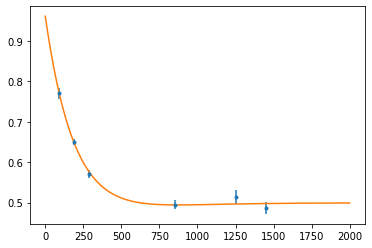

In [17]:
A = do_it_all()
print(A[-1])

In [5]:
print(A[-2])

        fwhm  time
0  0.855(30)  1250
1  0.811(24)  1450
2  1.082(12)   190
3  0.722(32)  1990
4  0.951(16)   290
5  0.944(16)   690
6  0.825(18)   850
7  1.282(23)    90
8  0.697(17)   990
